In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional


In [2]:
# Load and preprocess the data
df = pd.read_csv(r"D:\MCA\RBL\Final paper\new RBL\MY paper\Data\ICICIBANK.csv", parse_dates=['Date'], index_col='Date')
df = df.loc[:, ~df.columns.isin(['Series','Trades', 'Deliverable Volume', '%Deliverble'])]

train_size = int(len(df) * 0.8)
train_size1 = int(len(df) * 0.64)
train_size2 = int(len(df) * 0.25)
train_dataset, test_dataset = df.iloc[train_size2:train_size1], df.iloc[train_size1:train_size]

# Split train data to X and y
X_train = train_dataset.drop('Open', axis=1)
y_train = train_dataset.loc[:, ['Open']]

# Split test data to X and y
test_x = test_dataset.drop('Open', axis=1)
test_y = test_dataset.loc[:, ['Open']]

numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']
df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])

train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

X_train = train_data.drop(columns=['Symbol'] + numerical_cols)
y_train = train_data['Open']
X_test = test_data.drop(columns=['Symbol'] + numerical_cols)
y_test = test_data['Open']

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

train_x_norm = scaler_x.fit_transform(X_train)
train_y_norm = scaler_y.fit_transform(y_train.values.reshape(-1, 1)) # convert to numpy array and reshape
test_x_norm = scaler_x.transform(X_test)
test_y_norm = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (4214, 30, 3)
y_train.shape: (4214, 1)
X_test.shape: (1032, 30, 3)
y_test.shape: (1032, 1)


In [3]:
# Adaptive Genetic Algorithm
class AdaptiveGeneticAlgorithm:
    def __init__(self, population_size, num_genes, fitness_func):
        self.population_size = population_size
        self.num_genes = num_genes
        self.fitness_func = fitness_func
        self.population = np.random.uniform(low=0, high=1, size=(population_size, num_genes))
        self.best_individual = None
        self.best_fitness = None
    
    def evaluate_fitness(self):
        fitness_values = []
        for individual in self.population:
            fitness_values.append(self.fitness_func(individual))
        return np.array(fitness_values)
    
    def selection(self, fitness_values, num_parents):
        sorted_indices = np.argsort(fitness_values)
        parents = self.population[sorted_indices[:num_parents]]
        if parents.shape[0] == 0:
            parents = self.population[:1]  # Select one random parent if no parents were selected
        return parents
    
    def crossover(self, parents, offspring_size):
        offspring = np.empty(offspring_size)
        crossover_point = np.random.randint(low=0, high=self.num_genes)
        for i in range(offspring_size[0]):
            parent1_idx = i % parents.shape[0]
            parent2_idx = (i+1) % parents.shape[0]
            offspring[i, :crossover_point] = parents[parent1_idx, :crossover_point]
            offspring[i, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring
    
    def mutation(self, offspring):
        mutation_rate = 1 / self.num_genes
        for i in range(offspring.shape[0]):
            for j in range(offspring.shape[1]):
                if np.random.uniform() < mutation_rate:
                    offspring[i, j] = np.random.uniform(low=0, high=1)
        return offspring
    
    def optimize(self, num_generations):
        for generation in range(num_generations):
            fitness_values = self.evaluate_fitness()
            best_fitness_idx = np.argmin(fitness_values)
            best_fitness = fitness_values[best_fitness_idx]
            best_individual = self.population[best_fitness_idx]
            
            if self.best_fitness is None or best_fitness < self.best_fitness:
                self.best_fitness = best_fitness
                self.best_individual = best_individual
            
            parents = self.selection(fitness_values, num_parents=self.population_size//2)
            offspring = self.crossover(parents, offspring_size=(self.population_size-parents.shape[0], self.num_genes))
            offspring = self.mutation(offspring)
            
            self.population = np.concatenate((parents, offspring))
            
            print(f"Generation: {generation+1}")
            print(f"Best Fitness: {best_fitness}")
            print(f"Best Individual: {best_individual}")
            print("----------------------")
            
        print("Final Result:")
        print(f"Best Fitness: {self.best_fitness}")
        print(f"Best Individual: {self.best_individual}")
        return self.best_individual, self.best_fitness


In [4]:
def fitness_function(individual):
    lstm_units = int(individual[0] * 100) + 1
    
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units=lstm_units)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model and get the predictions
    model, history, train_predictions, test_predictions = fit_model(model, X_train, y_train, X_test, y_test)
    
    # Inverse transform the normalized predictions and true values
    train_predictions = scaler_y.inverse_transform(train_predictions)
    test_predictions = scaler_y.inverse_transform(test_predictions)
    y_train_true = scaler_y.inverse_transform(y_train)
    y_test_true = scaler_y.inverse_transform(y_test)
    
    # Calculate the mean squared error
    train_mse = np.mean(np.square(train_predictions - y_train_true))
    test_mse = np.mean(np.square(test_predictions - y_test_true))
    
    return test_mse

def fit_model(model, X_train, y_train, X_test, y_test):
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                        shuffle=False, callbacks=[early_stop])
    
    # Get the predictions for training and test data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    return model, history, train_predictions, test_predictions



In [5]:
# Create and run the Adaptive Genetic Algorithm
population_size = 10
num_genes = 5
num_generations = 10

ga = AdaptiveGeneticAlgorithm(population_size, num_genes, fitness_function)
best_individual, best_fitness = ga.optimize(num_generations)
lstm_units = int(best_individual[0] * 100) + 1


Epoch 1/100
132/132 [==============================] - 13s 64ms/step - loss: 0.0033 - val_loss: 0.0100
Epoch 2/100
132/132 [==============================] - 7s 56ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 3/100
132/132 [==============================] - 7s 56ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 4/100
132/132 [==============================] - 7s 56ms/step - loss: 0.0022 - val_loss: 7.5661e-04
Epoch 5/100
132/132 [==============================] - 7s 56ms/step - loss: 8.0567e-04 - val_loss: 7.2974e-05
Epoch 6/100
132/132 [==============================] - 8s 58ms/step - loss: 4.3079e-04 - val_loss: 5.3592e-05
Epoch 7/100
132/132 [==============================] - 8s 57ms/step - loss: 5.5498e-04 - val_loss: 8.4817e-05
Epoch 8/100
132/132 [==============================] - 8s 57ms/step - loss: 4.2200e-04 - val_loss: 4.9048e-05
Epoch 9/100
132/132 [==============================] - 7s 56ms/step - loss: 4.9441e-04 - val_loss: 7.5763e-05
Epoch 10/100
132/132 [===============

In [6]:
# Create the BiLSTM model using the optimized input parameters
model = Sequential()
model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Train and evaluate the model with the new parameters
model, history, train_predictions, test_predictions = fit_model(model, X_train, y_train, X_test, y_test)
loss = model.evaluate(X_test, y_test)
print('Model loss:', loss)




Epoch 1/100
132/132 [==============================] - 19s 62ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 2/100
132/132 [==============================] - 3s 26ms/step - loss: 0.0041 - val_loss: 6.0572e-04
Epoch 3/100
132/132 [==============================] - 4s 32ms/step - loss: 0.0016 - val_loss: 2.5545e-04
Epoch 4/100
132/132 [==============================] - 4s 32ms/step - loss: 0.0011 - val_loss: 1.4270e-04
Epoch 5/100
132/132 [==============================] - 4s 32ms/step - loss: 8.3553e-04 - val_loss: 2.4147e-04
Epoch 6/100
132/132 [==============================] - 4s 33ms/step - loss: 0.0012 - val_loss: 1.9677e-04
Epoch 7/100
132/132 [==============================] - 4s 32ms/step - loss: 8.4115e-04 - val_loss: 1.2610e-04
Epoch 8/100
132/132 [==============================] - 4s 33ms/step - loss: 0.0011 - val_loss: 2.5147e-04
Epoch 9/100
132/132 [==============================] - 4s 32ms/step - loss: 6.6716e-04 - val_loss: 1.0507e-04
Epoch 10/100
132/132 [===============

In [7]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# Inverse transform the normalized predictions and true values
train_predictions = scaler_y.inverse_transform(train_predictions)
test_predictions = scaler_y.inverse_transform(test_predictions)
y_train_true = scaler_y.inverse_transform(y_train)
y_test_true = scaler_y.inverse_transform(y_test)

# Calculate the mean squared error
train_mse = mean_squared_error(y_train_true, train_predictions)
test_mse = mean_squared_error(y_test_true, test_predictions)

# Calculate mean absolute error
train_mae = mean_absolute_error(y_train_true, train_predictions)
test_mae = mean_absolute_error(y_test_true, test_predictions)

# Calculate root mean squared error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate accuracy measure (e.g., R-squared score)
train_r2 = r2_score(y_train_true, train_predictions)
test_r2 = r2_score(y_test_true, test_predictions)



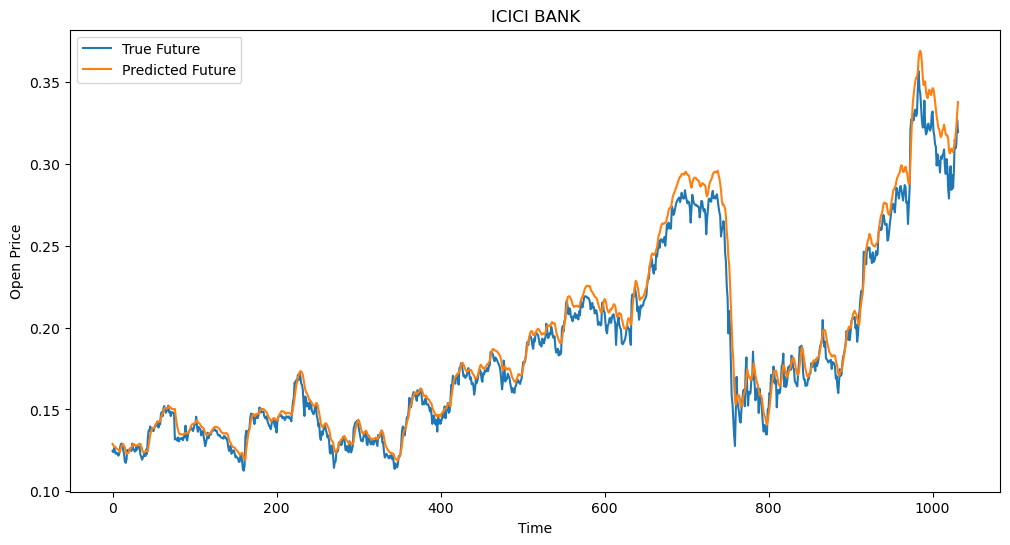

Train MSE: 0.0008791397604396733
Test MSE: 8.720489940673338e-05
Train MAE: 0.019831563484830044
Test MAE: 0.006778699753910986
Train RMSE: 0.02965029106838031
Test RMSE: 0.009338356354666134
Train R-squared: 0.983910309022597
Test R-squared: 0.9718005016940104


In [10]:
import matplotlib.pyplot as plt

# Plot the true future and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_true, label='True Future')
plt.plot(test_predictions, label='Predicted Future')
plt.title('ICICI BANK')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.legend()
plt.show()

print('Train MSE:', train_mse)
print('Test MSE:', test_mse)
print('Train MAE:', train_mae)
print('Test MAE:', test_mae)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Train R-squared:', train_r2)
print('Test R-squared:', test_r2)

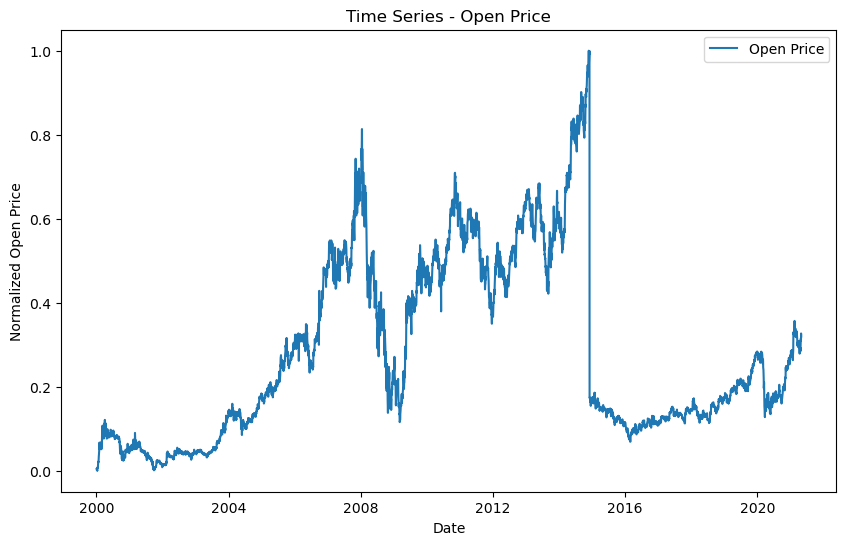

In [9]:
# Plotting the time series data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Open'], label='Open Price')
plt.xlabel('Date')
plt.ylabel('Normalized Open Price')
plt.title('Time Series - Open Price')
plt.legend()
plt.show()